ENM CPU Load Predictive Model
=============================


# 1.  Challenge Description


## 1.1 Dataset Description
This dataset in `data/` folder is based on real data extracted from DDP on
customer sites. The dataset contains data from 11 network operators and the
file names follow a name convention aiming at grouping the files by
network operator:

### JSON files:
Filename format: customer-<operator-id>-<service-group>.json
Content: list of supported nodes/features

### CSV files:
Format: <type-of-content>-<operator-id>-<service-group>-<start-of-date-range>-<end-of-date-range>.csv

type-of-content:

- features: counts of nodes per node-type per day; each column is a different node type, each row is a different day. The first row is the header.
- labels: CPU metrics collected daily every minute from all the servers in a service-group; each column is a CPU load reading in % time, each row is a different day. No header.
- dates: each row is a day for each row in features and labels files. No header.

## 1.2 Feature Description

The dataset is heavily anonymized. The real network-operator-id is replaced by a counter. The CSV containing the features is a CSV files having as column the type of nodes supported by ENM, as row the day the node volumes were measured, as cell-values the number of nodes divided by 10000. In `graph` folder there's an HTML file containing a Plotly graph per each operator having as Xs the content of the corresponding `dates` CSV file, a plot per every node type with node-counts as Ys, a plot for the CPU load, and a plot for the averaged CPU load over time.

## 1.3 Research Areas

This dataset can be used for both data exploration as well as modelling tasks.
In terms of modelling tasks, it can be used for both time-series modelling as
well as non-temporal tasks.

## 1.4 Challenge

The expected outcome of the produced model(s) is:
- to be able to tell how much CPU load a single node of every type is generating on a service-group 
- to be able to predict how much CPU load a combination of nodes outside the range of the training data will generate on a service-group
 

# 2. Initial Analyzis of CPU Load

The graph files contain very nice visual representation of node counts and processor load.  We suspect that these graph files are based on the csv files from the data directory.

In [33]:
data_dir = './ENM_Proc_Load/data/'
graph_dir = './ENM_Proc_Load/graph/'

There is only one operator where the observation period starts on 2018-04-01.  Let's have a look on the mscmce file.

In [34]:
graph_fname = 'nodecountbytype-vs-load-MLP-3308-742-mscmce-cpu-20180401-20180922.html'
with open(graph_dir + graph_fname) as f:
    html = f.read()

Trying to extract the data from html file with BeautifulSoup.

In [35]:
import bs4
soup = bs4.BeautifulSoup(html, 'lxml')

The graph data is stored in a script tag.

In [36]:
scripts = soup.select('script')

We are going to retain the element which contains the string 'max(CPU)'

In [37]:
data_script = [x.text for x in scripts if 'max(CPU)' in x.text][0]

Checking the element text.

In [38]:
data_script[:1111]

'window.PLOTLYENV=window.PLOTLYENV || {};window.PLOTLYENV.BASE_URL="https://plot.ly";Plotly.newPlot("0ec47031-2b6e-4956-86fa-773ff5422bab", [{"name": "max(CPU) %", "yaxis": "y2", "connectgaps": false, "x": ["2018-04-01", "2018-04-02", "2018-04-03", "2018-04-06", "2018-04-07", "2018-04-08", "2018-04-09", "2018-04-10", "2018-04-11", "2018-04-12", "2018-04-13", "2018-04-14", "2018-04-15", "2018-04-16", "2018-04-17", "2018-04-18", "2018-04-19", "2018-04-20", "2018-04-21", "2018-04-22", "2018-04-23", "2018-04-24", "2018-04-25", "2018-04-26", "2018-04-27", "2018-04-28", "2018-04-29", "2018-04-30", "2018-05-01", "2018-05-02", "2018-05-03", "2018-05-04", "2018-05-05", "2018-05-06", "2018-05-07", "2018-05-08", "2018-05-09", "2018-05-10", "2018-05-11", "2018-05-12", "2018-05-13", "2018-05-14", "2018-05-15", "2018-05-16", "2018-05-17", "2018-05-18", "2018-05-19", "2018-05-20", "2018-05-21", "2018-05-22", "2018-05-23", "2018-05-26", "2018-05-27", "2018-05-28", "2018-05-29", "2018-05-30", "2018-05-

In [39]:
data_script[-1111:]

'0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0], "type": "scatter"}], {"yaxis74": {"showticklabels": false, "overlaying": "y"}, "title": "#Node VS Load on MSCMCE (Swisscom_Zurich_ENM_Prod_LTE)", "yaxis2": {"title": "max(CPU) %", "overlaying": "y", "side": "right", "titlefont": {"color": "rgb(0, 0, 255)"}, "tickfont": {"color": "rgb(0, 0, 255)"}}, "yaxis48": {"showticklabels": false, "overlaying": "y"}, "yaxis59": {"showticklabels": false, "overlaying": "y"}, "xaxis": {"title": "Time"}, "yaxis78": {"showticklabels": false, "overlaying": "y"}, "yaxis": {"title": "Node Count"}, "yaxis36": {"showticklabels": false, "overlaying": "y"}, "yaxis63": {"showticklabels": false, "overlaying": "y"}, "yaxis14": {"showticklabels": false, "overlaying": "y"}, "yaxis42": {"showticklabels": false, "overlaying": "y"}, "yaxis5": {"showticklabels": false, "overlaying": "y"}

It looks like the `Plotly.newPlot` function is called with all the data as argument.  We are going to extract this function call.

In [40]:
plot_func_text = data_script.split('Plotly.')[1]

Defining our own `newPlot()` function which is going to convert the text to data.

In [41]:
def newPlot(_id, data, legend, link):
    return data
true = True
false = False

In [42]:
data = eval(plot_func_text)
print('data type:', type(data))
print('type of first element in the list:', type(data[0]))
print('keys of the first list element:', data[0].keys())

data type: <class 'list'>
type of first element in the list: <class 'dict'>
keys of the first list element: dict_keys(['name', 'yaxis', 'connectgaps', 'x', 'y', 'line', 'type'])


It looks like one list element contains x and y values for a feature or result.  Let's check the 'name' key for each element.

In [43]:
for i, d in enumerate(data):
    print(i, d['name'])

0 max(CPU) %
1 Mean max(CPU) %
2 Node Count
3 BSP
4 EPG
5 MSRBS_V1
6 RadioNode
7 SAPC
8 SGSN-MME
9 WMG
10 vCSCF
11 vSBG
12 vWMG


Reading the data into a pandas dataframe.

In [44]:
import pandas as pd

cols = [data[0]['x']] + [d['y'] for d in data]
df = pd.concat([pd.Series(x) for x in cols], axis=1)
df.columns =  ['date'] + [d['name'] for d in data]


In [45]:
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,max(CPU) %,Mean max(CPU) %,Node Count,BSP,EPG,MSRBS_V1,RadioNode,SAPC,SGSN-MME,WMG,vCSCF,vSBG,vWMG
0,2018-04-01,19.054120,19.054120,3327.0,0.0,4.0,35.0,3260.0,2.0,4.0,18.0,1.0,1.0,2.0
1,2018-04-02,19.641258,19.347689,3327.0,0.0,4.0,35.0,3260.0,2.0,4.0,18.0,1.0,1.0,2.0
2,2018-04-03,27.368516,22.021298,3336.0,0.0,4.0,35.0,3268.0,2.0,4.0,19.0,1.0,1.0,2.0
3,2018-04-06,17.986223,17.986223,3343.0,0.0,4.0,35.0,3272.0,2.0,4.0,22.0,1.0,1.0,2.0
4,2018-04-07,12.042165,12.042165,3343.0,0.0,4.0,35.0,3272.0,2.0,4.0,22.0,1.0,1.0,2.0


In [46]:
%matplotlib inline

import matplotlib.pyplot as plt

Reproducing the `max(CPU) %` and `Mean max(CPU) %` graphs with the extracted data.

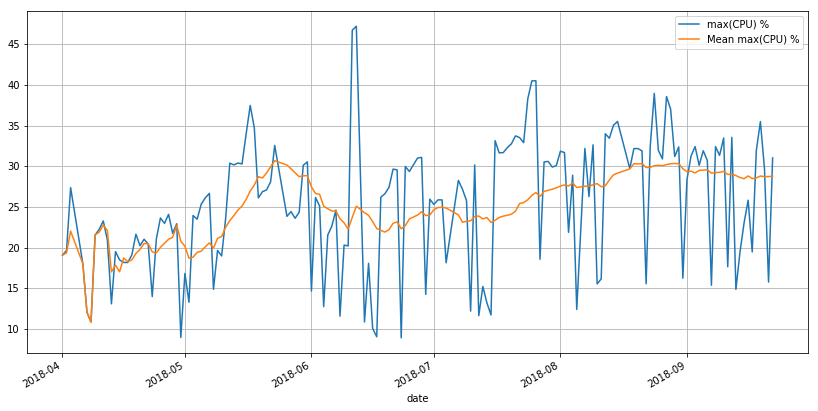

In [47]:
df.plot(x='date',y=['max(CPU) %','Mean max(CPU) %'], grid=True, figsize=(14,7))

The reproduction is looks like the plot in the original html file, meaning that data extraction was successful.

We are going to correspond this CPU load with data extracted from the .csv files.

In [48]:
labels_fname = 'labels-003-mscmce-cpu-20180401-20180922.csv'

In [49]:
import csv

with open(data_dir + labels_fname, newline='') as csvfile:
    reader = csv.reader(csvfile)
    label_max_CPU = []
    for row in reader:
        row = [int(float(x)) for x in row if x]
        label_max_CPU.append(max(row))
        

In [50]:
df['Label max(CPU) %'] = pd.Series(label_max_CPU)

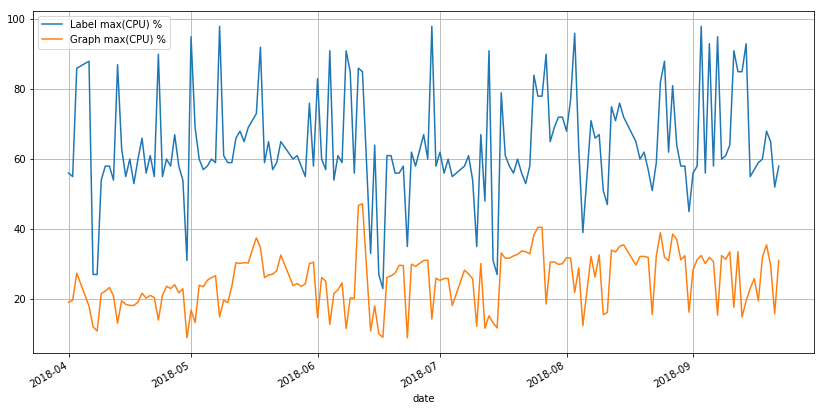

In [51]:
df.rename(columns={'max(CPU) %':'Graph max(CPU) %'}, inplace=True)
df.plot(x='date',y=['Label max(CPU) %', 'Graph max(CPU) %'], grid=True, figsize=(14,7))

Houston we have a problem!

I was expecting that the `max(CPU)%` in data files and in graph files are equal.

Got help from Patrizio Bruno P.  The reason for the difference: 
> *"The data in the graphs has been obtained by averaging the peak values (values higher than the standard deviation) per day."*

Ok. Let's try to replicate this.

In [52]:
import numpy as np

with open(data_dir + labels_fname, newline='') as csvfile:
    reader = csv.reader(csvfile)
    avg_std_CPU = []
    for row in reader:
        row = [int(float(x)) for x in row if x]
        std = np.std(row)
        avg = np.average(row)
        avg_std = [x for x in row if x >= avg + std]
        avg_std_CPU.append(np.average(avg_std))


In [53]:
df['>Avg+Std(CPU) %'] = pd.Series(avg_std_CPU)

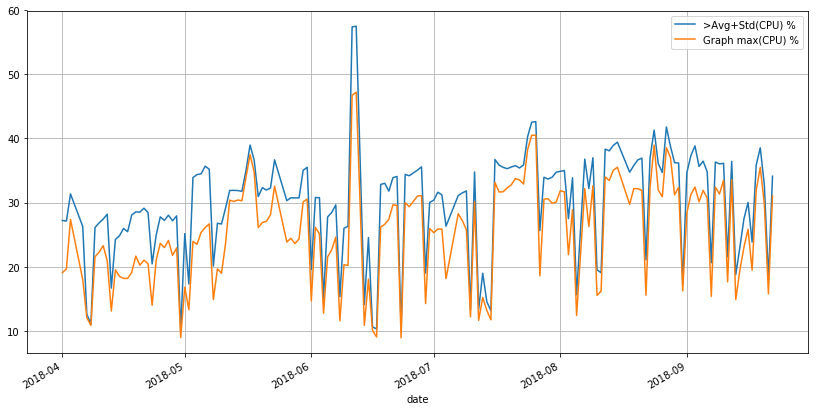

In [54]:
df.plot(x='date',y=['>Avg+Std(CPU) %', 'Graph max(CPU) %'], grid=True, figsize=(14,7))

This looks like a much better approach.  Although the two curves doesn't overlap but we can see that they are based on the same data series, we just didn't succeded to grap the exact formula.

However this means the game is open, we can come up with our own formulas.  During a day there are about 10000..20000 processor load measurement values -- we have to decide what values are we going to predict.

Let's add a column with average and one with stdev values.

In [55]:
with open(data_dir + labels_fname, newline='') as csvfile:
    reader = csv.reader(csvfile)
    avgs = []
    stds = []
    for row in reader:
        row = [int(float(x)) for x in row if x]
        std = np.std(row)
        avg = np.average(row)
        stds.append(std)
        avgs.append(avg)
        
df['Avg(CPU) %'] = pd.Series(avgs)
df['Std(CPU) %'] = pd.Series(stds)

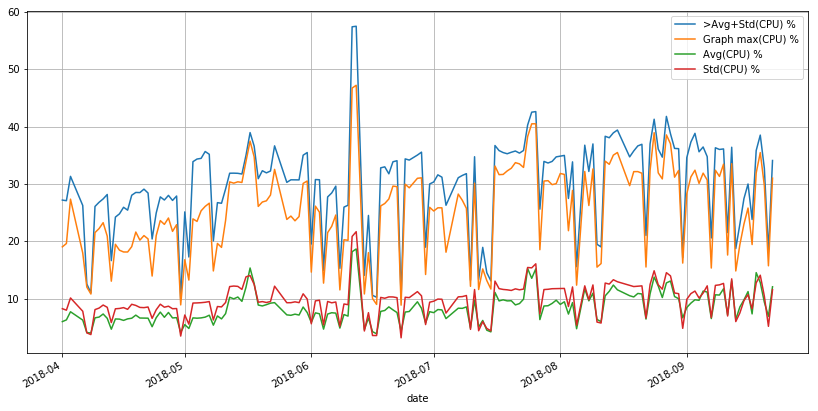

In [56]:
df.plot(x='date',y=['>Avg+Std(CPU) %', 'Graph max(CPU) %', 'Avg(CPU) %', 'Std(CPU) %'], grid=True, figsize=(14,7))

It looks like there is a strong correlation between average values and standard deviation.

This means that whenever the average CPU load increases then we will get some busy minutes with high processor load.
Let's try to visualise the daily distribution of the CPU load.



 2018-04-01


C:\Users\ethneat\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


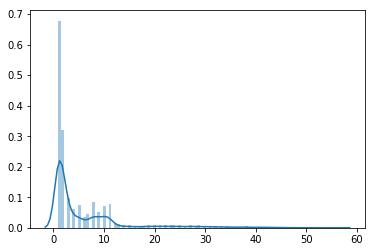



 2018-04-02


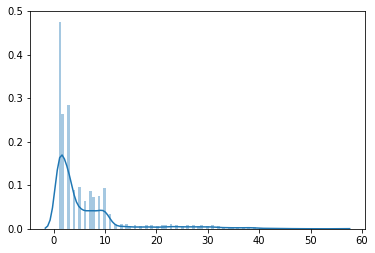



 2018-04-03


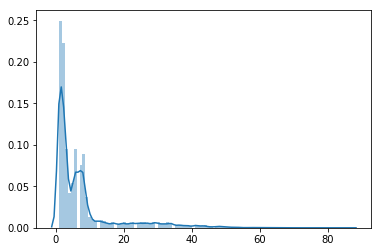



 2018-04-04


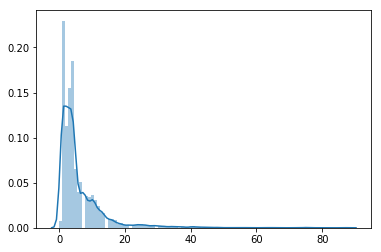



 2018-04-05


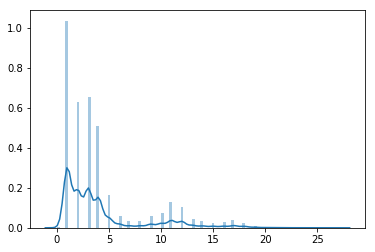



 2018-04-06


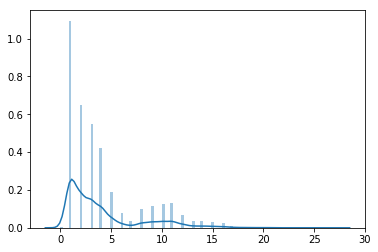



 2018-04-07


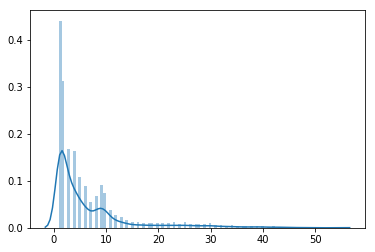



 2018-04-08


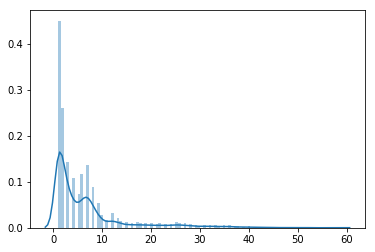



 2018-04-09


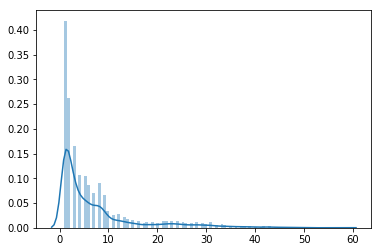



 2018-04-10


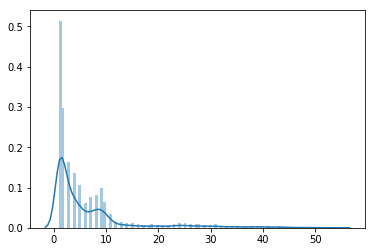



 2018-04-11


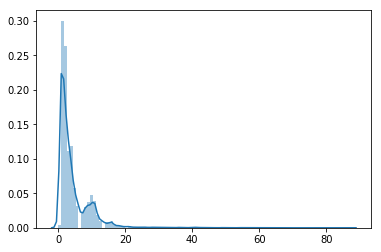



 2018-04-12


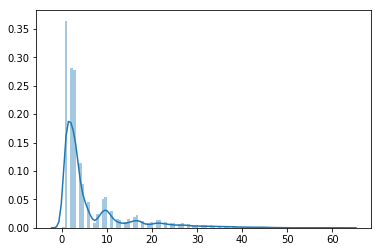



 2018-04-13


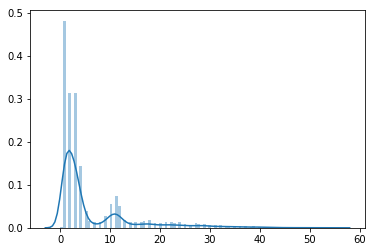



 2018-04-14


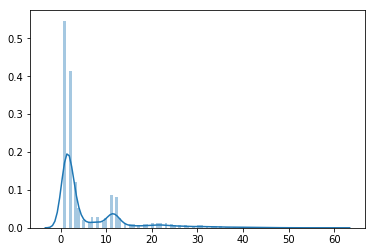



 2018-04-15


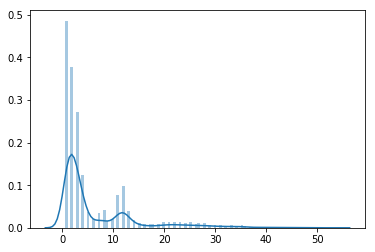



 2018-04-16


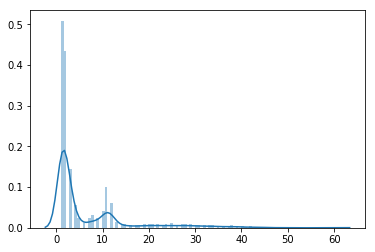



 2018-04-17


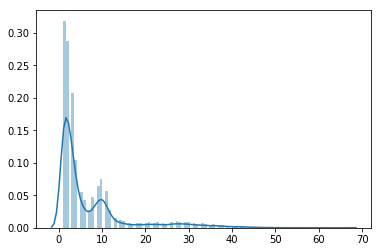



 2018-04-18


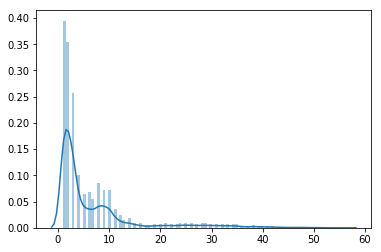



 2018-04-19


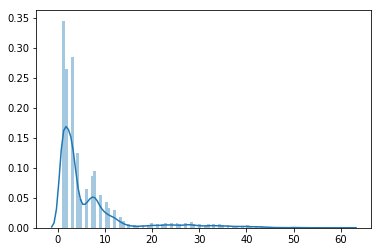



 2018-04-20


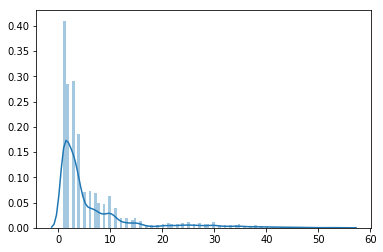



 2018-04-21


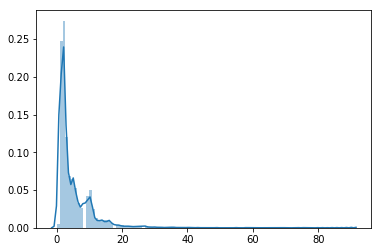



 2018-04-22


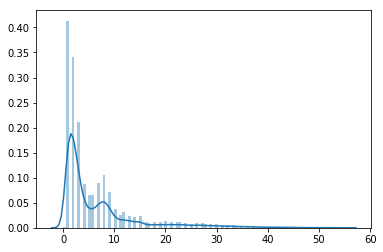



 2018-04-23


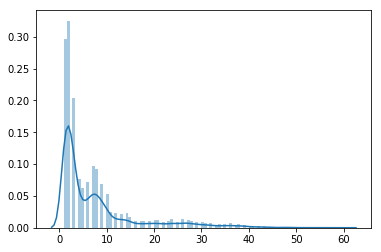



 2018-04-24


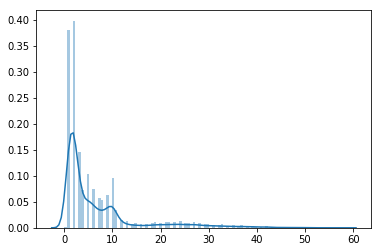



 2018-04-25


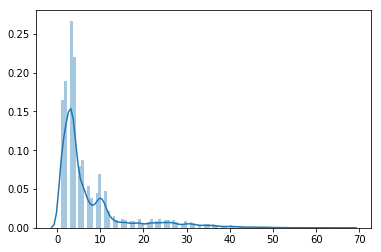



 2018-04-26


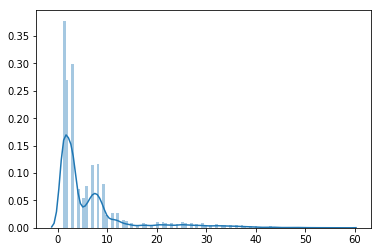



 2018-04-27


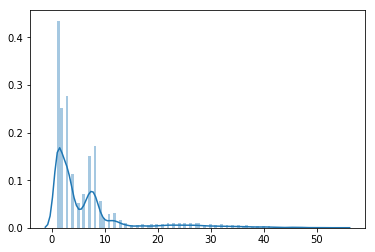



 2018-04-28


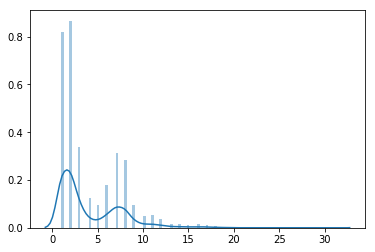



 2018-04-29


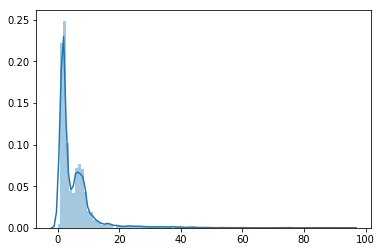



 2018-04-30


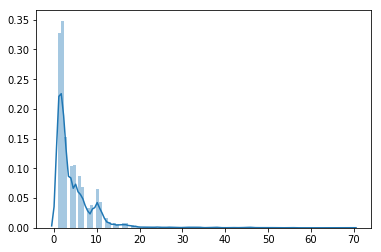



 2018-05-01


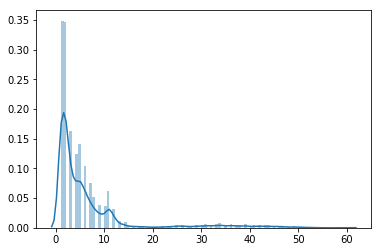



 2018-05-02


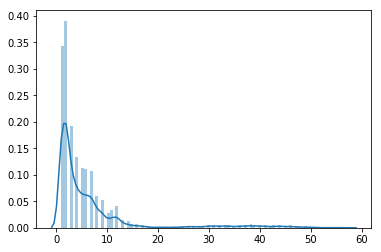



 2018-05-03


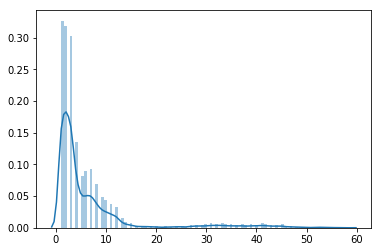



 2018-05-04


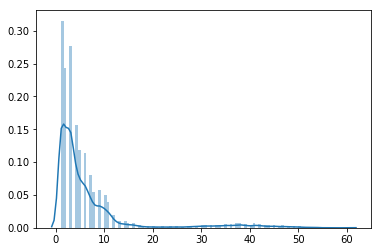



 2018-05-05


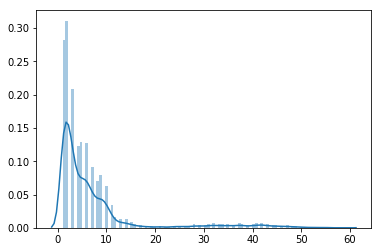



 2018-05-06


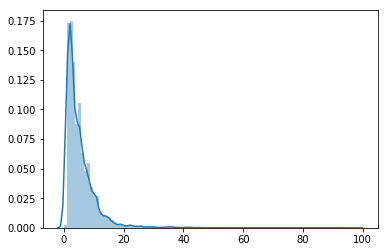



 2018-05-07


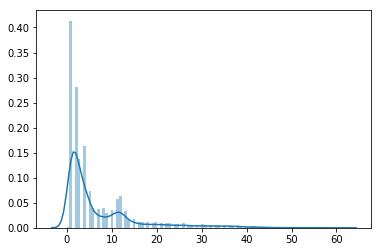



 2018-05-08


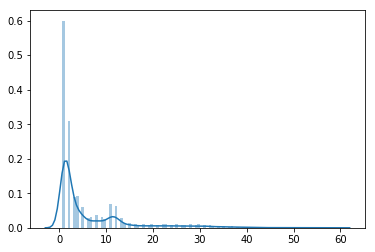



 2018-05-09


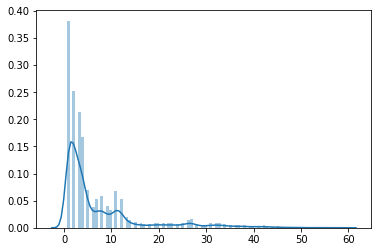



 2018-05-10


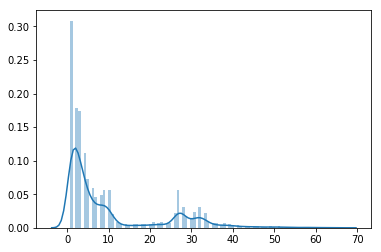



 2018-05-11


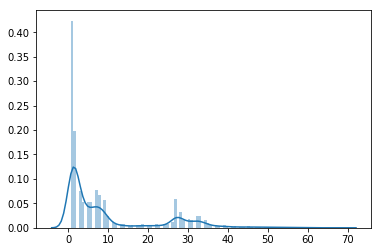



 2018-05-12


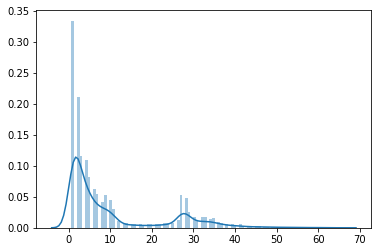



 2018-05-13


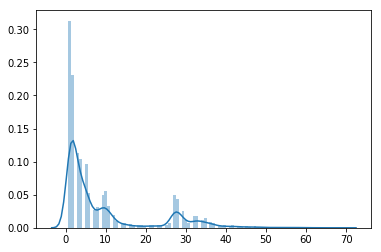



 2018-05-14


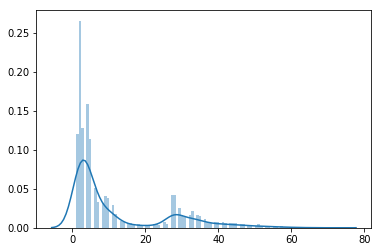



 2018-05-15


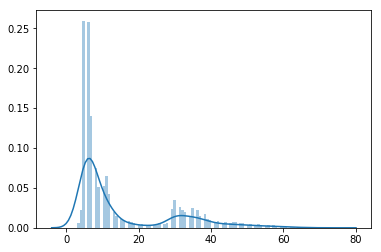



 2018-05-16


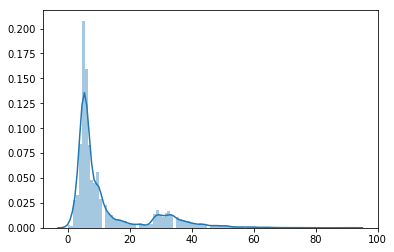



 2018-05-17


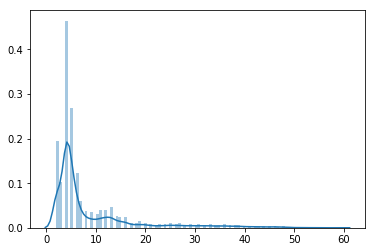



 2018-05-18


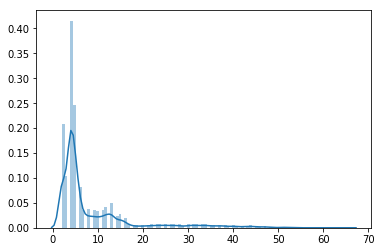



 2018-05-19


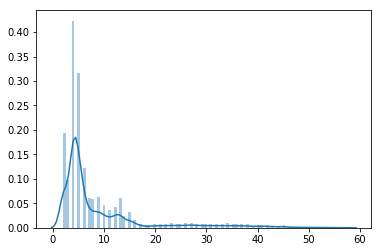



 2018-05-20


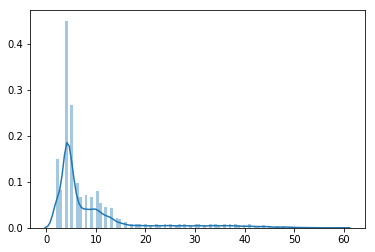



 2018-05-21


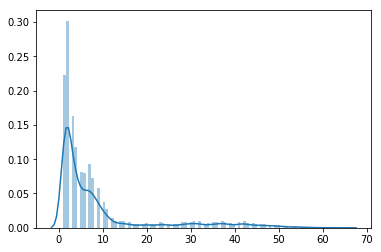



 2018-05-22


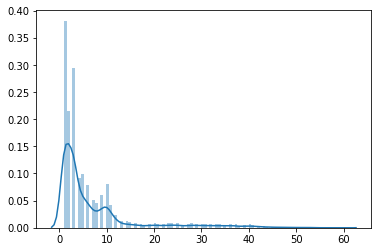



 2018-05-23


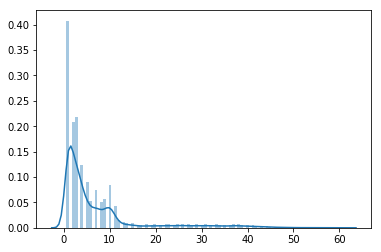



 2018-05-24


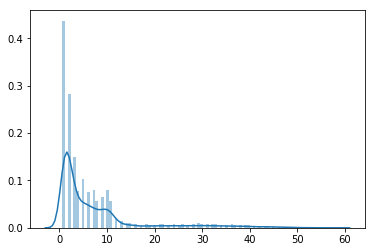



 2018-05-25


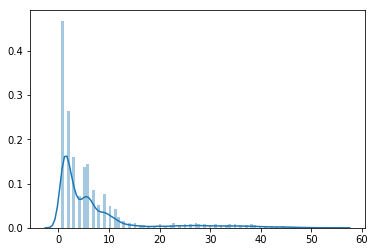



 2018-05-26


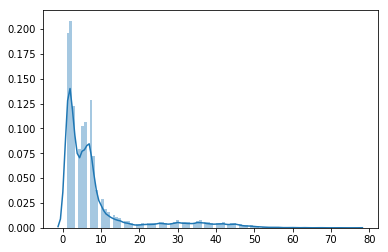



 2018-05-27


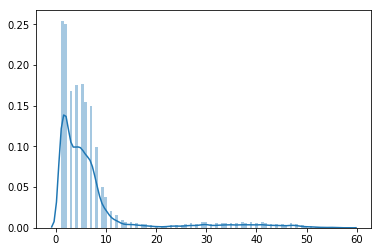



 2018-05-28


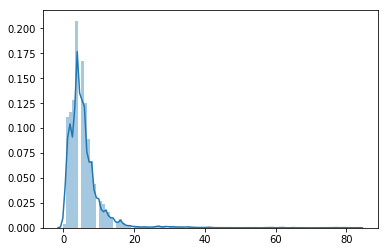



 2018-05-29


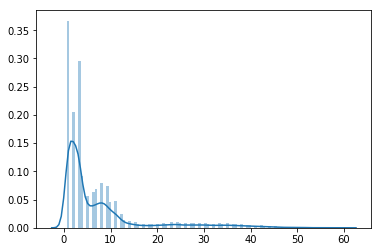



 2018-05-30


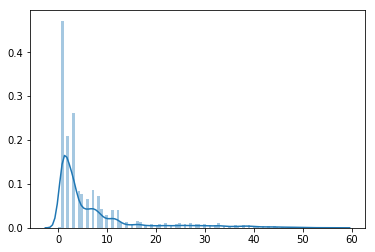



 2018-05-31


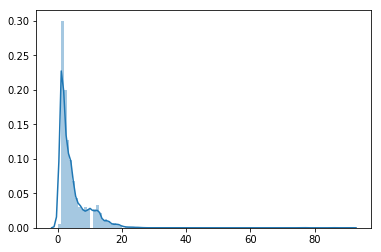



 2018-06-01


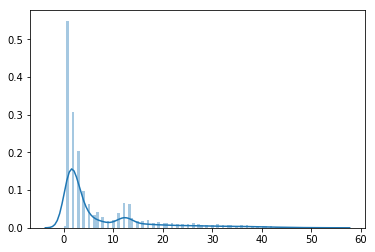



 2018-06-02


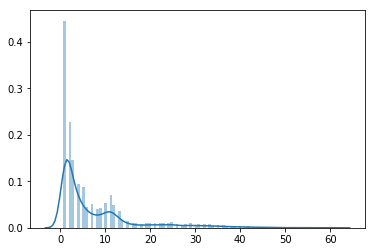



 2018-06-03


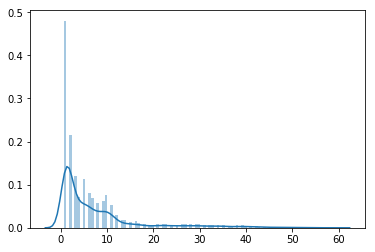



 2018-06-04


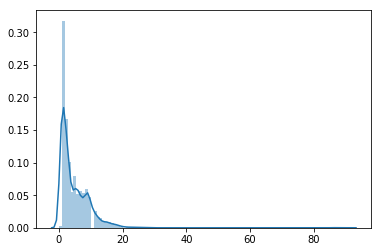



 2018-06-05


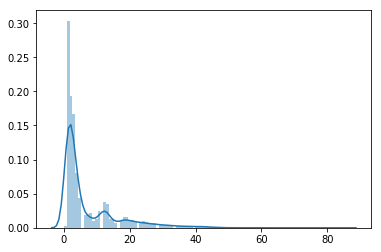



 2018-06-06


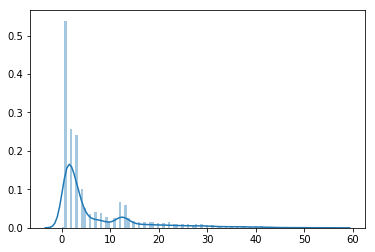



 2018-06-07


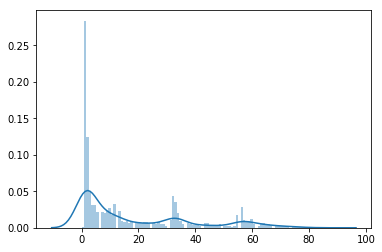



 2018-06-08


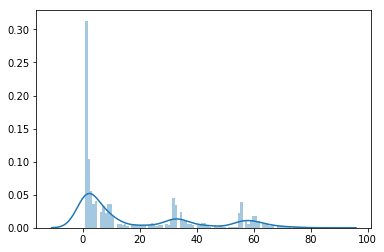



 2018-06-09


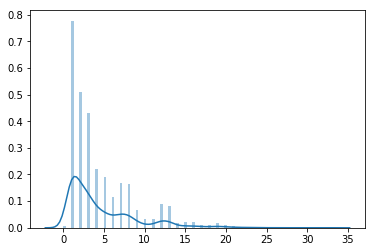



 2018-06-10


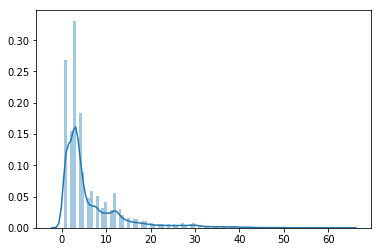



 2018-06-11


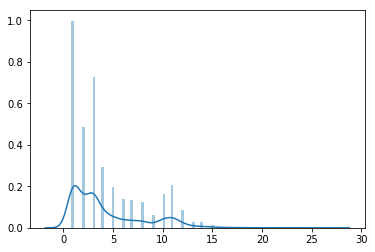



 2018-06-12


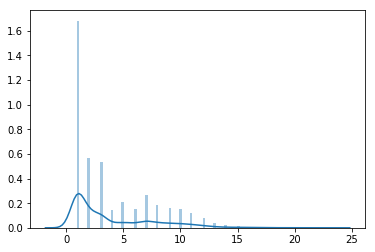



 2018-06-13


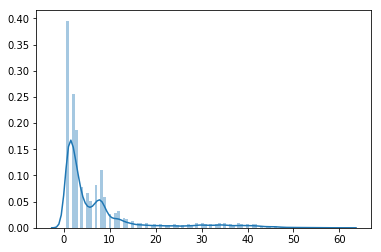



 2018-06-14


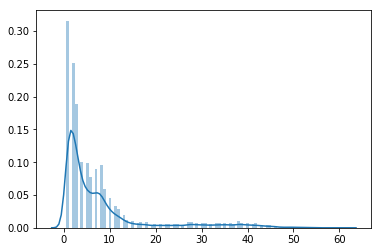



 2018-06-15


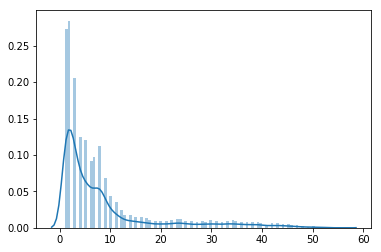



 2018-06-16


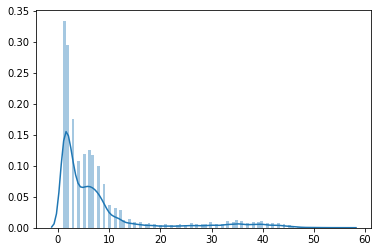

In [57]:
import datetime

date = datetime.datetime(2018,4,1)
for i in range(77):
    print('\n\n',date.strftime('%Y-%m-%d'))
    date += datetime.timedelta(days=1)
    sns.distplot(day[i], bins=100)
    plt.show()

The most CPU load samples are around ~2..3%.  When the average daily CPU load increases, we still have most of the samples at ~2..3% load but we are getting more samples in the higher range of more than 20% .. 50% .

One more observation: the average daily CPU load values are not in a normal distribution either.  A normal distribution would be symmetric around the average with most of the values being at 3 stdev from the average.  In our case the average is around 7..10%, the stdev is around 10% and the value range is in 0..100% so we got a skewed distribution.

In [25]:
import seaborn as sns

C:\Users\ethneat\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


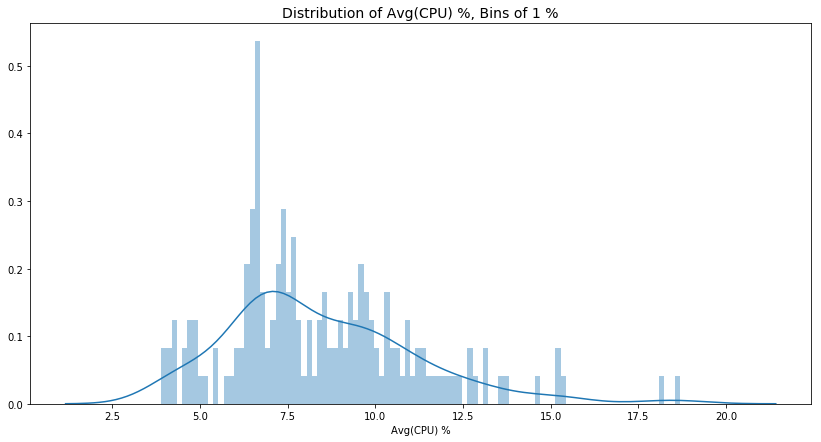

In [26]:
plt.figure(figsize=(14,7))
sns.distplot( df['Avg(CPU) %'],bins=100)
plt.title('Distribution of Avg(CPU) %, Bins of 1 %', fontsize=14)
plt.show()

As suspected we have an assymetrical distribution.  If average processor load would be closer to 50% then our distribution could be symmetrical.

On the labels data we have variable number of measurements every day.  Let's look at it closer maybe we can find there something.

In [27]:
with open(data_dir + labels_fname, newline='') as csvfile:
    reader = csv.reader(csvfile)
    nr_meas = []
    for row in reader:
        row = [int(float(x)) for x in row if x]
        nr_meas.append(len(row))
        
df['Nr Measurement'] = pd.Series(nr_meas)
df['Nr Servers'] = df['Nr Measurement']/1440  # 1440 measurement in a day for 1 server instance

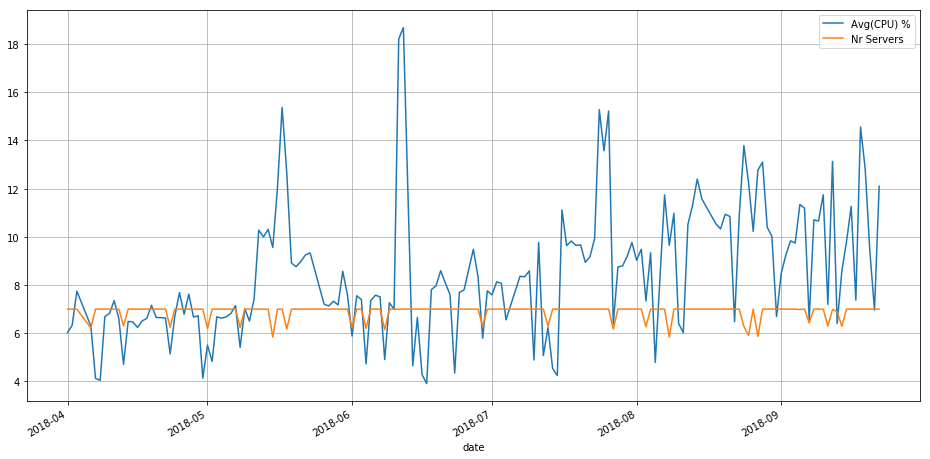

In [28]:
df.plot(x='date', y=['Avg(CPU) %', 'Nr Servers'], grid=True, figsize=(16,8))

This operator has 7 server instances working normally but from time to time this is reduced to about ~6 servers.  We don't know whether the servers were offline or simply measurement values have been lost.

In [29]:
df.columns

Index(['date', 'Graph max(CPU) %', 'Mean max(CPU) %', 'Node Count', 'BSP',
       'EPG', 'MSRBS_V1', 'RadioNode', 'SAPC', 'SGSN-MME', 'WMG', 'vCSCF',
       'vSBG', 'vWMG', 'Label max(CPU) %', '>Avg+Std(CPU) %', 'Avg(CPU) %',
       'Std(CPU) %', 'Nr Measurement', 'Nr Servers'],
      dtype='object')

After we had some insights about the processor load we are going to remove all columns referring to CPU load but one.

`Avg(CPU) %` is going to be kept and we are going to predict this value.

In [30]:
df.drop(axis=1, columns=['Graph max(CPU) %', 'Mean max(CPU) %', 'Label max(CPU) %', 
                                             '>Avg+Std(CPU) %', 'Std(CPU) %', 'Nr Measurement', 'Nr Servers'], inplace=True)

# 3 Analyzing Features

## 3.1 Importing Features from CSV Files

Currently our feature values are the ones extracted from the graph html file.  We are now importing feature values from CSV files to see how they compare to the graph data values.

First we are going to check the data types in our dataframe.

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 13 columns):
date          164 non-null datetime64[ns]
Node Count    164 non-null float64
BSP           164 non-null float64
EPG           164 non-null float64
MSRBS_V1      164 non-null float64
RadioNode     164 non-null float64
SAPC          164 non-null float64
SGSN-MME      164 non-null float64
WMG           164 non-null float64
vCSCF         164 non-null float64
vSBG          164 non-null float64
vWMG          164 non-null float64
Avg(CPU) %    164 non-null float64
dtypes: datetime64[ns](1), float64(12)
memory usage: 16.7 KB


Converting node numbers to int.

In [32]:
df[['Node Count', 'BSP', 'EPG', 'MSRBS_V1', 'RadioNode', 
    'SAPC', 'SGSN-MME', 'WMG', 'vCSCF', 'vSBG', 'vWMG']] = df[['Node Count', 'BSP', 'EPG', 'MSRBS_V1', 'RadioNode', 
                                                               'SAPC', 'SGSN-MME', 'WMG', 'vCSCF', 'vSBG', 'vWMG']].astype(int)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 13 columns):
date          164 non-null datetime64[ns]
Node Count    164 non-null int32
BSP           164 non-null int32
EPG           164 non-null int32
MSRBS_V1      164 non-null int32
RadioNode     164 non-null int32
SAPC          164 non-null int32
SGSN-MME      164 non-null int32
WMG           164 non-null int32
vCSCF         164 non-null int32
vSBG          164 non-null int32
vWMG          164 non-null int32
Avg(CPU) %    164 non-null float64
dtypes: datetime64[ns](1), float64(1), int32(11)
memory usage: 9.7 KB


Checking supported nodes for this operator.

In [34]:
import json

supported_nodes_fname = 'customer-003-mscmce.json'

with open(data_dir + supported_nodes_fname) as f:
    supported_nodes_text = f.read()
    supported_nodes = json.loads(supported_nodes_text)['supported_nodes']
    print(supported_nodes)

['BSP', 'EPG', 'MSRBS_V1', 'RadioNode', 'SAPC', 'SGSN-MME', 'WMG', 'vCSCF', 'vSBG', 'vWMG']


These node types correspond to the node types in the graph html file.

In [35]:
features_fname = 'features-003-mscmce-cpu-20180401-20180922.csv'

with open(data_dir + features_fname, newline='') as csvfile:
    reader = csv.reader(csvfile)
    headers = next(reader)
    headers = [h.strip() for h in headers]   # header row: "BGF, BSC, BSP, CCN-TSP ..." - stripping the leading space
    column = {}
    for h in headers:
        column[h] = []
    for row in reader:
        for h, v in zip(headers, row):
            val = round(10000 * float(v))  # should be used round; when using int we might loose a few nodes
            column[h].append(val)

csv_nodes = []
for node in headers:
    if sum(column[node]) > 0:
        csv_nodes.append(node)
        df['csv '+ node] = pd.Series(column[node])

print(supported_nodes)
print(csv_nodes)


['BSP', 'EPG', 'MSRBS_V1', 'RadioNode', 'SAPC', 'SGSN-MME', 'WMG', 'vCSCF', 'vSBG', 'vWMG']
['BSP', 'EME', 'MSC-DB-BSP', 'RBS', 'RVNFM', 'SBG-IS', 'vBNG', 'vEPG', 'VTFRadioNode', 'WMG']


Column names in features csv files seems to be wrong.

In [36]:
for sn, cn in zip(supported_nodes, csv_nodes):
    print(f"{sn:10} {sum(df[sn]):10} {sum(df['csv '+cn]):10}    {'csv '+cn:10}")

BSP                99         99    csv BSP   
EPG               656        656    csv EME   
MSRBS_V1         6191       6191    csv MSC-DB-BSP
RadioNode      572902     572902    csv RBS   
SAPC              701        701    csv RVNFM 
SGSN-MME          820        820    csv SBG-IS
WMG              3597       3597    csv vBNG  
vCSCF             164        164    csv vEPG  
vSBG              164        164    csv VTFRadioNode
vWMG              328        328    csv WMG   


Despite wrong column names in the feature csv files the values seems to correspond to the values in the graph.  

It is worth mentioning that e.g. `0.0003 * 10000 = 2.9999999` therefore the `round` function should be used instead of the `int` built-in when converting the float values in csv files to integers.

In [37]:
df.columns

Index(['date', 'Node Count', 'BSP', 'EPG', 'MSRBS_V1', 'RadioNode', 'SAPC',
       'SGSN-MME', 'WMG', 'vCSCF', 'vSBG', 'vWMG', 'Avg(CPU) %', 'csv BSP',
       'csv EME', 'csv MSC-DB-BSP', 'csv RBS', 'csv RVNFM', 'csv SBG-IS',
       'csv vBNG', 'csv vEPG', 'csv VTFRadioNode', 'csv WMG'],
      dtype='object')

Since we don't have new information in the csv columns we are going to delete them.

In [38]:
df.drop(axis=1, columns=['csv BSP', 'csv EME', 'csv MSC-DB-BSP', 'csv RBS', 'csv RVNFM', 'csv SBG-IS',
                                                   'csv vBNG', 'csv vEPG', 'csv VTFRadioNode', 'csv WMG'], inplace=True)

In [39]:
df.head()

,date,Node Count,BSP,EPG,MSRBS_V1,RadioNode,SAPC,SGSN-MME,WMG,vCSCF,vSBG,vWMG,Avg(CPU) %
0,2018-04-01,3327,0,4,35,3260,2,4,18,1,1,2,6.023131
1,2018-04-02,3327,0,4,35,3260,2,4,18,1,1,2,6.327211
2,2018-04-03,3336,0,4,35,3268,2,4,19,1,1,2,7.741487
3,2018-04-06,3343,0,4,35,3272,2,4,22,1,1,2,6.290986
4,2018-04-07,3343,0,4,35,3272,2,4,22,1,1,2,4.118833


## 3.2 Engineering Features

Right now we have as features only the node numbers which are changing slowly and certainly don't present that hectic variation that we could see at CPU load.  This means that there are many other operations done by ENM and most of the day-to-day variation can be attributed to those unknown factors.

### 3.2.1 Convert Date Column to Many Columns

The idea is from [fast.ai](http://www.fast.ai/) machine learning course: a date is not simply a number but it has more meanings which we are going to extract in separate columns.

In [40]:
import re

def add_datepart(df, fldname, drop=False):
    '''Function taken from https://github.com/fastai/fastai ; tailored for our needs'''
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Day', 'Dayofweek', 'Is_month_end', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
    if drop: 
        df.drop(fldname, axis=1, inplace=True)


In [41]:
add_datepart(df, 'date', drop=False)

The date column is redundant so we are keeping it as index.

In [42]:
df.set_index('date', inplace=True)

In [43]:
df.head()

,Node Count,BSP,EPG,MSRBS_V1,RadioNode,SAPC,SGSN-MME,WMG,vCSCF,vSBG,vWMG,Avg(CPU) %,Day,Dayofweek,Is_month_end,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
date,,,,,,,,,,,,,,,,,,,
2018-04-01,3327,0,4,35,3260,2,4,18,1,1,2,6.023131,1,6,False,False,True,False,False
2018-04-02,3327,0,4,35,3260,2,4,18,1,1,2,6.327211,2,0,False,False,False,False,False
2018-04-03,3336,0,4,35,3268,2,4,19,1,1,2,7.741487,3,1,False,False,False,False,False
2018-04-06,3343,0,4,35,3272,2,4,22,1,1,2,6.290986,6,4,False,False,False,False,False
2018-04-07,3343,0,4,35,3272,2,4,22,1,1,2,4.118833,7,5,False,False,False,False,False


Let's take a quick look on a heatmap.

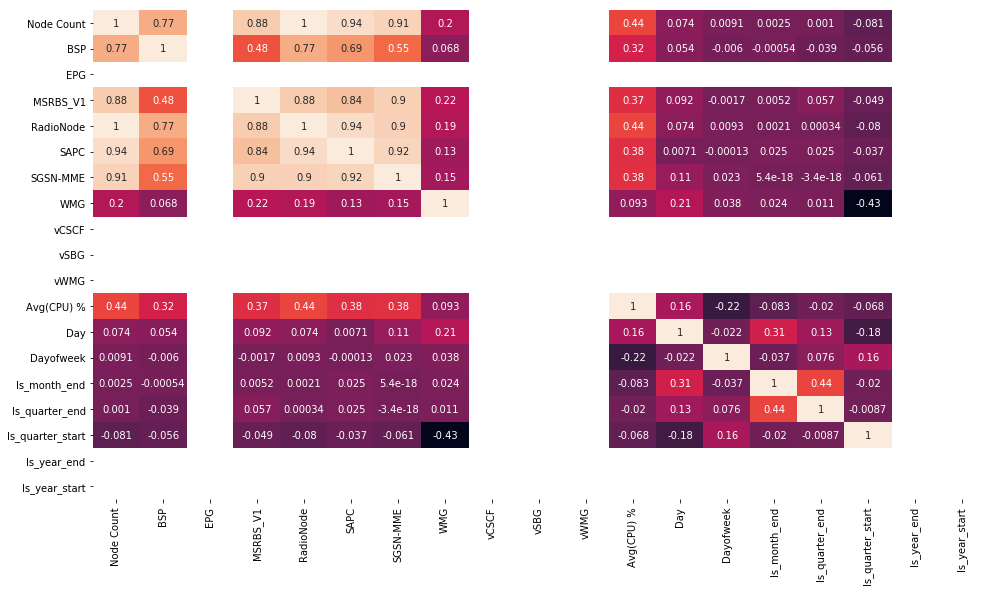

In [44]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(), annot=True, cbar=False)

We can see from the above heatmap that daily average CPU load is mostly correlated with `Node Count`, `RadioNode`, `SAPC`, `SGSN-MME`, `MSRBS_V1`, `BSP`and the `Day` of the month.

### 3.2.2 Calculating the Delta Node Number

One more idea worth checking is that maybe the processor load is influenced by the works ongoing on the network.  We could modelate this by calcualting the difference of the nodes from one day to the next day.

In [45]:
node_numbers = ['Node Count'] + supported_nodes
delta_node_numbers = ['Delta '+ n for n in node_numbers]
df[delta_node_numbers] = df[node_numbers].diff().fillna(0).astype(int)

A quick look on the heatmap with the new columns:

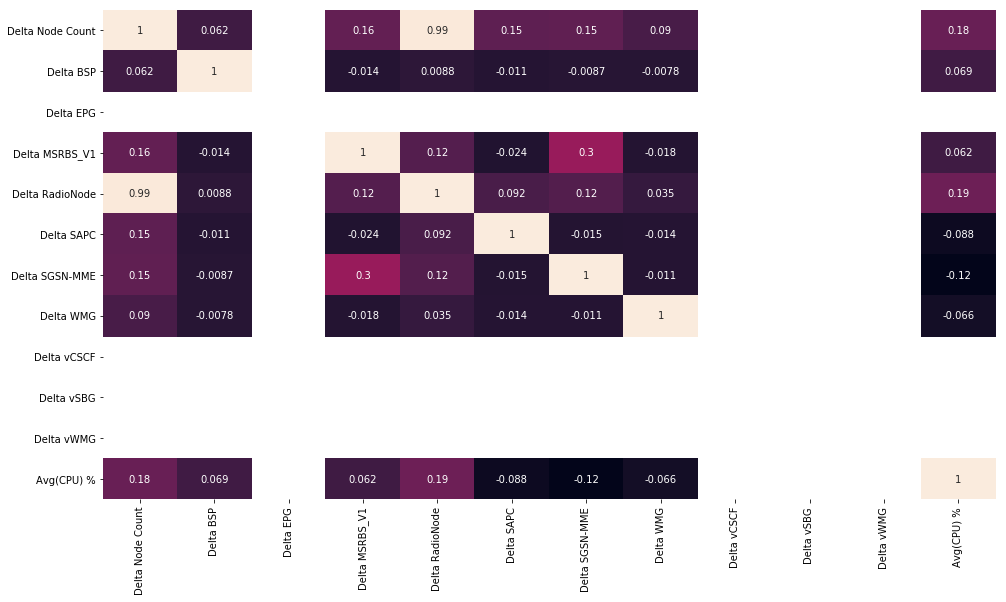

In [46]:
plt.figure(figsize=(16,9))
sns.heatmap(df[delta_node_numbers + ['Avg(CPU) %']].corr(), annot=True, cbar=False)

It looks like the `Delta Node Count` and the `Delta RadioNode` have influence on the CPU load therefore we are going to keep these Delta columns for our analyzis.

# 4. Predicting Processor Load with Random Forest Regression

We are going to use the Random Forest Regression because we have only a small amount of samples a relatively low number of parameters.

## 4.1 Checkpoint

Before beginning the operations let's make a checkpoint.  It was a long journey till we arrived here and it would be wise to save the dataframe.

In [47]:
import os

temp_dir = './ENM_Proc_Load/temp/'
os.makedirs(temp_dir, exist_ok=True)

In [48]:
# !pip install feather-format
import feather
df.reset_index(inplace=True) # feather likes only default index
df.to_feather(temp_dir + 'op3-mscmce.ftr')

In the future we can continue from this point

In [49]:
df = pd.read_feather(temp_dir + 'op3-mscmce.ftr', nthreads=1)
df.set_index('date', inplace=True)

C:\Users\ethneat\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\io\feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


## 4.2 Initial Model

In [50]:
df.columns

Index(['Node Count', 'BSP', 'EPG', 'MSRBS_V1', 'RadioNode', 'SAPC', 'SGSN-MME',
       'WMG', 'vCSCF', 'vSBG', 'vWMG', 'Avg(CPU) %', 'Day', 'Dayofweek',
       'Is_month_end', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end',
       'Is_year_start', 'Delta Node Count', 'Delta BSP', 'Delta EPG',
       'Delta MSRBS_V1', 'Delta RadioNode', 'Delta SAPC', 'Delta SGSN-MME',
       'Delta WMG', 'Delta vCSCF', 'Delta vSBG', 'Delta vWMG'],
      dtype='object')

The dependent variable is the processor load.

In [51]:
y = df['Avg(CPU) %']

The features are the rest of the columns.

In [52]:
df.drop('Avg(CPU) %', axis=1, inplace=True)

In [53]:
X = df

In [54]:
X_train, X_test = X[:-22], X[-22:]

In [55]:
y_train, y_test = y[:-22], y[-22:]

Training with RandomForestRegressor

In [56]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_jobs=-1, random_state=22)
rfr.fit(X_train, y_train)

C:\Users\ethneat\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=22, verbose=0, warm_start=False)

In [57]:
rfr.score(X_test, y_test)

-0.23473586401165325

A negative R^2 score doesn't look very promising.  However we wasn't expecting a good prediction since we could see on the graphs that the CPU load is jumping from day to day to different values while the features represented by node numbers have little variation.  To be more precise these are the delta node changes in the last 22 days (the test period).

In [58]:
mask = (X_test[delta_node_numbers] != 0).any()
X_test[mask.index[mask]]

,Delta Node Count,Delta MSRBS_V1,Delta RadioNode,Delta SAPC
date,,,,
2018-09-01,0,0,0,0
2018-09-02,0,0,0,0
2018-09-03,6,0,6,0
2018-09-04,5,0,5,0
2018-09-05,2,0,2,0
2018-09-06,9,0,9,0
2018-09-07,5,0,5,0
2018-09-08,0,0,0,0
2018-09-09,0,0,0,0


Now let's have a look that these changes what CPU load produced in the real life and in our predictions.

In [59]:
y_pred = rfr.predict(X_test)

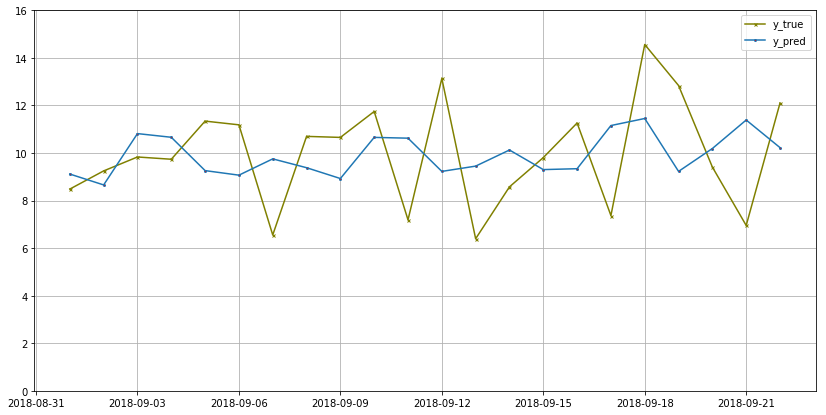

In [60]:
from matplotlib.pyplot import figure
figure(figsize=(14,7))
plt.plot( df.index[-22:] , y_test, marker='x', color='olive', markerfacecolor='red', markersize=3, label = 'y_true')
plt.plot( df.index[-22:] , y_pred, marker='o', markerfacecolor='red', markersize=2, label='y_pred')
axes = plt.gca()
axes.set_ylim([0,16])
plt.legend()
plt.grid()

We can see that in fact our model is not so bad.  Tries to catch the day-to-day variance of the CPU load, it doesn't succeed, but the average value is about right.

## 4.3 Improving the Model

Let's try to improve our model with RandomizedSearchCV.

In [61]:
from sklearn.model_selection import RandomizedSearchCV

# nr of trees in random forest
n_estimators = [20, 50, 100, 200, 500, 1000]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [10, 20, 50, 100, 200, None]

# Minimum number of samples required to split a node
min_samples_split = [2, 4]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


In [62]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                                                           n_iter = 100, cv = 3, verbose=1, random_state=22, n_jobs = 1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.4min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'n_estimators': [20, 50, 100, 200, 500, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 50, 100, 200, None], 'min_samples_split': [2, 4], 'min_samples_leaf': [1, 2]},
          pre_dispatch='2*n_jobs', random_state=22, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [63]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 20}

In [64]:
rfr = rf_random.best_estimator_
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [65]:
rfr.score(X_test, y_test)

0.03692493172347888

It is nice to see that our R^2 score turns into positive :-)

Let's plot the new CPU load prediction.

In [66]:
y_pred = rfr.predict(X_test)

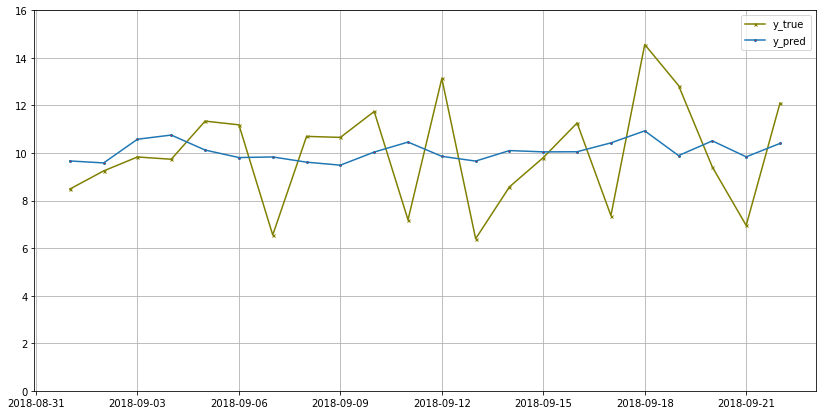

In [67]:
figure(figsize=(14,7))
plt.plot( df.index[-22:] , y_test, marker='x', color='olive', markerfacecolor='red', markersize=3, label = 'y_true')
plt.plot( df.index[-22:] , y_pred, marker='o', markerfacecolor='red', markersize=2, label='y_pred')
axes = plt.gca()
axes.set_ylim([0,16])
plt.legend()
plt.grid()

Our improved model shows some signs of "intelligence".  It realized that has no chance to guess the day-by-day variations of the CPU load so it decided that staying around the average is a sure bet.

## 4.4 Feature Importances

One great advantage of Random Forest Model is that it can tell us the importance of every feature.

In [68]:
rfr.feature_importances_

array([2.23027518e-01, 2.27814727e-02, 0.00000000e+00, 5.87701870e-02,
       2.13561925e-01, 4.41565380e-02, 6.67664447e-02, 1.81942379e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.09846326e-01,
       9.26753185e-02, 1.51571420e-03, 0.00000000e+00, 9.99078540e-05,
       0.00000000e+00, 0.00000000e+00, 6.58761032e-02, 0.00000000e+00,
       0.00000000e+00, 7.81866302e-03, 6.66604751e-02, 2.28422383e-03,
       3.69422808e-03, 2.83012929e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [69]:
dffi = pd.DataFrame({'feature': X.columns, 'importance %': rfr.feature_importances_ * 100})

Listing the 10 most important parameters:

In [70]:
dffi.sort_values(by='importance %', ascending=False)[:10]

,feature,importance %
0,Node Count,22.302752
4,RadioNode,21.356192
11,Day,10.984633
12,Dayofweek,9.267532
6,SGSN-MME,6.676644
22,Delta RadioNode,6.666048
18,Delta Node Count,6.587610
3,MSRBS_V1,5.877019
5,SAPC,4.415654
1,BSP,2.278147


We can see that RadioNode has importance of ~20% while SGSN-MME has an importance of ~10%.  Does this mean that 1 RadioNode is contributing more to ENM processor load than 1 SGSN-MME node?  Not really.  Our feature importance dataframe is missing 2 more columns: the starting and finishing node counts.  Let's add those.

In [71]:
dffi['first_value'] = X_train.iloc[0].values
dffi['last_value'] = X_train.iloc[-1].values

In [72]:
dffi.sort_values(by='importance %', ascending=False)[:10]

,feature,importance %,first_value,last_value
0,Node Count,22.302752,3327,3792
4,RadioNode,21.356192,3260,3706
11,Day,10.984633,1,31
12,Dayofweek,9.267532,6,4
6,SGSN-MME,6.676644,4,6
22,Delta RadioNode,6.666048,0,6
18,Delta Node Count,6.587610,0,7
3,MSRBS_V1,5.877019,35,39
5,SAPC,4.415654,2,8
1,BSP,2.278147,0,3


As an approximation for the Node Equivalence solution we could consider that adding ~500 RadioNodes contribute with ~20% of processor load and adding 2 SGSN-MME nodes contribute with ~10 of the processor load change.  

However we just realize that we made a mistake.  We have amongst the features the `Node Count` column and this doesn't give us new information, but basically it is just duplicating the RadioNode count.  Let's correct this mistake to have a better approximation.

## 4.5 First Approximation of the Network Element Equivalence Predictor

First we are going to remove the `Node Count` column and we are going to retrain our model.

In [73]:
X.columns

Index(['Node Count', 'BSP', 'EPG', 'MSRBS_V1', 'RadioNode', 'SAPC', 'SGSN-MME',
       'WMG', 'vCSCF', 'vSBG', 'vWMG', 'Day', 'Dayofweek', 'Is_month_end',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Delta Node Count', 'Delta BSP', 'Delta EPG', 'Delta MSRBS_V1',
       'Delta RadioNode', 'Delta SAPC', 'Delta SGSN-MME', 'Delta WMG',
       'Delta vCSCF', 'Delta vSBG', 'Delta vWMG'],
      dtype='object')

In [74]:
X.drop('Node Count', axis=1, inplace=True)

In [75]:
X_train, X_test = X[:-22], X[-22:]

In [76]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                                                           n_iter = 100, cv = 3, verbose=1, random_state=22, n_jobs = 1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.4min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'n_estimators': [20, 50, 100, 200, 500, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 50, 100, 200, None], 'min_samples_split': [2, 4], 'min_samples_leaf': [1, 2]},
          pre_dispatch='2*n_jobs', random_state=22, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [77]:
rf_random.best_params_

{'n_estimators': 50,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 200}

In [78]:
rfr = rf_random.best_estimator_
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=200,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [79]:
rfr.score(X_test, y_test)

0.051725814235632606

Creating the dataframe with Feature Importances.

In [80]:
dffi = pd.DataFrame({'feature': X_train.columns, 'importance %': rfr.feature_importances_ * 100,
                                            'first_value': X_train.iloc[0].values, 'last_value': X_train.iloc[-1].values})

Listing the 10 most important parameters:

In [81]:
dffi.sort_values(by='importance %', ascending=False)[:10]

,feature,importance %,first_value,last_value
3,RadioNode,25.849776,3260,3706
10,Day,14.260411,1,31
5,SGSN-MME,11.521696,4,6
11,Dayofweek,9.707092,6,4
21,Delta RadioNode,8.510599,0,6
4,SAPC,8.118408,2,8
2,MSRBS_V1,7.548721,35,39
17,Delta Node Count,7.047738,0,7
0,BSP,2.064684,0,3
20,Delta MSRBS_V1,0.578546,0,0


Keeping only rows counting the supported nodes.

In [82]:
dffi = dffi[dffi['feature'].isin(supported_nodes)].sort_values(by='importance %', ascending=False)
dffi.reset_index(inplace=True, drop=True)
dffi

,feature,importance %,first_value,last_value
0,RadioNode,25.849776,3260,3706
1,SGSN-MME,11.521696,4,6
2,SAPC,8.118408,2,8
3,MSRBS_V1,7.548721,35,39
4,BSP,2.064684,0,3
5,WMG,0.041998,18,22
6,EPG,0.000000,4,4
7,vCSCF,0.000000,1,1
8,vSBG,0.000000,1,1
9,vWMG,0.000000,2,2


Adding column counting the difference in node numbers from start to end of training period.

In [83]:
dffi['node_diff'] = dffi['last_value'] - dffi['first_value']

In [84]:
dffi

,feature,importance %,first_value,last_value,node_diff
0,RadioNode,25.849776,3260,3706,446
1,SGSN-MME,11.521696,4,6,2
2,SAPC,8.118408,2,8,6
3,MSRBS_V1,7.548721,35,39,4
4,BSP,2.064684,0,3,3
5,WMG,0.041998,18,22,4
6,EPG,0.000000,4,4,0
7,vCSCF,0.000000,1,1,0
8,vSBG,0.000000,1,1,0
9,vWMG,0.000000,2,2,0


We are going to consider the RadioNode as a reference and we are going to express the rest of the nodes how many RadioNodes would require to cause the same variation of ENM CPU load.

In [85]:
def ne_eq(row, reference_imp, reference_node_diff):
    if row['importance %'] == 0:
        return None
    else:
        return abs(reference_node_diff / (reference_imp / row['importance %'] * row['node_diff']))

In [86]:
reference_imp = dffi[dffi['feature']=='RadioNode']['importance %'].values[0]
reference_node_diff = dffi[dffi['feature']=='RadioNode']['node_diff'].values[0]

In [87]:
dffi['RadioNode Eq'] = dffi.apply(ne_eq, args=(reference_imp, reference_node_diff), axis=1)

In [88]:
dffi

,feature,importance %,first_value,last_value,node_diff,RadioNode Eq
0,RadioNode,25.849776,3260,3706,446,1.000000
1,SGSN-MME,11.521696,4,6,2,99.394991
2,SAPC,8.118408,2,8,6,23.345207
3,MSRBS_V1,7.548721,35,39,4,32.560530
4,BSP,2.064684,0,3,3,11.874367
5,WMG,0.041998,18,22,4,0.181151
6,EPG,0.000000,4,4,0,NaN
7,vCSCF,0.000000,1,1,0,NaN
8,vSBG,0.000000,1,1,0,NaN
9,vWMG,0.000000,2,2,0,NaN


At first glance looks Ok.  
- One SGSN-MME is connected to many RadioNodes so it seems reasonable that one SGSN-MME is causing a CPU load as ~50 RadioNodes.
- SAPC and BSP is handling considerable traffic so causing CPU load of ~10..30 RadioNodes seems to be acceptable.

However one MSRBS_V1 to be equivalent with ~30
RadioNodes it is against my expectations.  The MSRBS_V1 is the little brother of the RadioNode (its "nickname" is PicoRBS) and I was expecting that it would cause much less trouble for the ENM than a RadioNode.

## 4.6 Approximation of the CPU Load Caused by a RadioNode

We are going to add a column to our dataframe with the number of difference expressed in equivalent RadioNodes:

In [89]:
dffi['delta RadioNode'] = dffi['node_diff'] * dffi['RadioNode Eq']
dffi

,feature,importance %,first_value,last_value,node_diff,RadioNode Eq,delta RadioNode
0,RadioNode,25.849776,3260,3706,446,1.000000,446
1,SGSN-MME,11.521696,4,6,2,99.394991,198.79
2,SAPC,8.118408,2,8,6,23.345207,140.071
3,MSRBS_V1,7.548721,35,39,4,32.560530,130.242
4,BSP,2.064684,0,3,3,11.874367,35.6231
5,WMG,0.041998,18,22,4,0.181151,0.724606
6,EPG,0.000000,4,4,0,NaN,NaN
7,vCSCF,0.000000,1,1,0,NaN,NaN
8,vSBG,0.000000,1,1,0,NaN,NaN
9,vWMG,0.000000,2,2,0,NaN,NaN


Let's calculate the processor load at the start and at the end of the training period considering a 20 day mean value.

In [90]:
proc_load_start, proc_load_end = y_train[:20].mean(), y_train[-20:].mean()
proc_load_start, proc_load_end

(6.303121487404822, 10.369512675397404)

Calculating the delta CPU load caused by our nodes:

In [91]:
delta_proc_load = (proc_load_end - proc_load_start) * dffi['importance %'].sum() / 100
delta_proc_load

2.242422920163828

Finally the CPU load caused by a RadioNode:

In [92]:
proc_load_RadioNode = delta_proc_load / dffi['delta RadioNode'].sum()
print(f'CPU Load caused by 1 RadioNode on op3 MSCMCE server instance = {proc_load_RadioNode:.5f} %')

CPU Load caused by 1 RadioNode on op3 MSCMCE server instance = 0.00236 %


Please note this values should be taken with a pinch of salt, because:
- we are not sure if Random Forest feature importances can be used directly in quantitative computations
- we made computations with a limited number of datapoints
- we made computations only for a given operator and we don't know if ENM CPU capacity is the same for all ENM implementations
- ENM software version might affect CPU load and we have no information about the SW version (additionally ENM might have been upgraded during the observation period)
- the CPU load caused by a NE element is depending on many factors, I guess the most important is that how many counters and measurements are activated on the respective node

# 5. Applying the NE Equivalence Approximation Process to the MSCM Server

We are going to define a `graph_to_df` function which is going to extract the date and the node count from the graph files.

In [93]:
def graph_to_df(graph_fname):
    '''extract the date and the node numbers from the graph files.'''
    with open(graph_dir + graph_fname) as f:
        html = f.read()
        soup = bs4.BeautifulSoup(html, 'lxml')
        scripts = soup.select('script')
        data_script = [x.text for x in scripts if 'max(CPU)' in x.text][0]
        plot_func_text = data_script.split('Plotly.')[1]
        data = eval(plot_func_text)
        cols = [data[0]['x']] + [d['y'] for d in data]
        df = pd.concat([pd.Series(x) for x in cols], axis=1)
        df.columns =  ['date'] + [d['name'] for d in data]
        df.drop(['max(CPU) %', 'Mean max(CPU) %', 'Node Count'], axis=1, inplace=True)
        df[df.columns[1:]] = df[df.columns[1:]].astype(int)
        df['date'] = pd.to_datetime(df['date'])
        return df

Applying this function to the Operator3 MSCM server:

In [94]:
df = graph_to_df('nodecountbytype-vs-load-MLP-3308-742-mscm-cpu-20180401-20180922.html')
df.head()

,date,ERBS,RBS
0,2018-04-01,1923,9163
1,2018-04-02,1923,9163
2,2018-04-03,1920,9161
3,2018-04-06,1917,9165
4,2018-04-07,1917,9165


The function `add_avg_cpu` is going to add the `AVG(CPU) %` column to the dataframe extracted from the csv files.

In [95]:
def add_avg_cpu(df, labels_fname):
    """add 'Avg(CPU) %' column to the df"""
    with open(data_dir + labels_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        avgs = []
        for row in reader:
            row = [int(float(x)) for x in row if x]
            avg = np.average(row)
            avgs.append(avg)
    if len(df) != len(avgs):
        raise ValueError('There is a gempa in the number of Avg CPU values!') 
    df['Avg(CPU) %'] = pd.Series(avgs)
    return df


Adding CPU load of Operator3 MSCM server to the dataframe:

In [96]:
df = add_avg_cpu(df, 'labels-003-mscm-cpu-20180401-20180922.csv')
df.head()

,date,ERBS,RBS,Avg(CPU) %
0,2018-04-01,1923,9163,1.636355
1,2018-04-02,1923,9163,1.864972
2,2018-04-03,1920,9161,1.950958
3,2018-04-06,1917,9165,2.146731
4,2018-04-07,1917,9165,1.527152


Splitting the `date` column into many columns and setting the index:

In [97]:
add_datepart(df, 'date', drop=False)
df.set_index('date', inplace=True)

df.head()

,ERBS,RBS,Avg(CPU) %,Day,Dayofweek,Is_month_end,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
date,,,,,,,,,,
2018-04-01,1923,9163,1.636355,1,6,False,False,True,False,False
2018-04-02,1923,9163,1.864972,2,0,False,False,False,False,False
2018-04-03,1920,9161,1.950958,3,1,False,False,False,False,False
2018-04-06,1917,9165,2.146731,6,4,False,False,False,False,False
2018-04-07,1917,9165,1.527152,7,5,False,False,False,False,False


Defining function `add_delta_node` and applying it to df:

In [98]:
def add_delta_node(df):
    supported_nodes = df.columns[:-8]
    delta_node_numbers = ['Delta '+ n for n in supported_nodes]
    df[delta_node_numbers] = df[supported_nodes].diff().fillna(0).astype(int)
    return df, supported_nodes

In [99]:
df, supported_nodes = add_delta_node(df)
df.head()

,ERBS,RBS,Avg(CPU) %,Day,Dayofweek,Is_month_end,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Delta ERBS,Delta RBS
date,,,,,,,,,,,,
2018-04-01,1923,9163,1.636355,1,6,False,False,True,False,False,0,0
2018-04-02,1923,9163,1.864972,2,0,False,False,False,False,False,0,0
2018-04-03,1920,9161,1.950958,3,1,False,False,False,False,False,-3,-2
2018-04-06,1917,9165,2.146731,6,4,False,False,False,False,False,-3,4
2018-04-07,1917,9165,1.527152,7,5,False,False,False,False,False,0,0


Checkpoint:

In [100]:
def checkpoint(df, fname):
    df.reset_index(inplace=True) # feather likes only default index
    df.to_feather(temp_dir + fname)
    df = pd.read_feather(temp_dir + fname, nthreads=1)
    df.set_index('date', inplace=True)
    return df

In [101]:
df = checkpoint(df, 'op3-mscm.ftr')

C:\Users\ethneat\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\io\feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [102]:
def train_test_split(df):
    y = df['Avg(CPU) %']
    df.drop('Avg(CPU) %', axis=1, inplace=True)
    X = df
    return X, y, X[:-22], X[-22:], y[:-22], y[-22:]

In [103]:
X, y, X_train, X_test, y_train, y_test = train_test_split(df)

In [104]:
len(X), len(y), len(X_train), len(X_test), len(y_train), len(y_test)

(164, 164, 142, 22, 142, 22)

The function `df_feat_imp` is going to create dffi - the feature importance dataframe.

In [105]:
def df_feat_imp(X_train, y_train, supported_nodes):
    random_grid = {'n_estimators': [20, 50, 100, 200, 500, 1000], # nr of trees
                   'max_features': ['auto', 'sqrt'],              # Number of features to consider at every split
                   'max_depth': [10, 20, 50, 100, 200, None],     # Maximum number of levels in tree
                   'min_samples_split': [2, 4],                   # Minimum number of samples required to split a node
                   'min_samples_leaf': [1, 2]}                    # Minimum number of samples required at each leaf node
    rf = RandomForestRegressor()
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                                    n_iter = 100, cv = 3, verbose=1, random_state=22, n_jobs = 1)
    rf_random.fit(X_train, y_train)
    rfr = rf_random.best_estimator_

    rfr.fit(X_train, y_train)
    dffi = pd.DataFrame({'feature': X_train.columns, 'importance %': rfr.feature_importances_ * 100,
                                            'first_value': X_train.iloc[0].values, 'last_value': X_train.iloc[-1].values})
    dffi = dffi[dffi['feature'].isin(supported_nodes)].sort_values(by='importance %', ascending=False)
    dffi.reset_index(inplace=True, drop=True)
    dffi['node_diff'] = dffi['last_value'] - dffi['first_value']
    return dffi

In [106]:
dffi = df_feat_imp(X_train, y_train, supported_nodes)
dffi

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.4min finished


,feature,importance %,first_value,last_value,node_diff
0,ERBS,20.424094,1923,1639,-284
1,RBS,19.458387,9163,9231,68


The function `com_ref` is going to the equivalent columns relative to the choosen node type.

In [123]:
def comp_ref(dffi, ref_node):
    reference_imp = dffi[dffi['feature']==ref_node]['importance %'].values[0]
    reference_node_diff = dffi[dffi['feature']==ref_node]['node_diff'].values[0]
    dffi[f'{ref_node} Eq'] = dffi.apply(ne_eq, args=(reference_imp, reference_node_diff), axis=1)
    dffi[f'delta {ref_node}'] = dffi['node_diff'] * dffi[f'{ref_node} Eq']
    return dffi

In our case the reference node will be the `ERBS` because every operator seems to have `ERBS` node on MSCM.

In [108]:
dffi = comp_ref(dffi, 'ERBS')
dffi

,feature,importance %,first_value,last_value,node_diff,ERBS Eq,delta ERBS
0,ERBS,20.424094,1923,1639,-284,1.000000,-284
1,RBS,19.458387,9163,9231,68,3.978996,270.572


During our observation period 284 ERBS have been decomissioned and 68 new RBS have been installed.  According to our calculations 1 RBS is causing an ENM CPU load as ~3 ERBS.

If we calculate in ERBS Eq this means that our install base is more than 30,000 ERBS Eq and during the observation period it has been decomissioned ~50 ERBS Eq.  This change in node count should not cause an observable CPU load change.

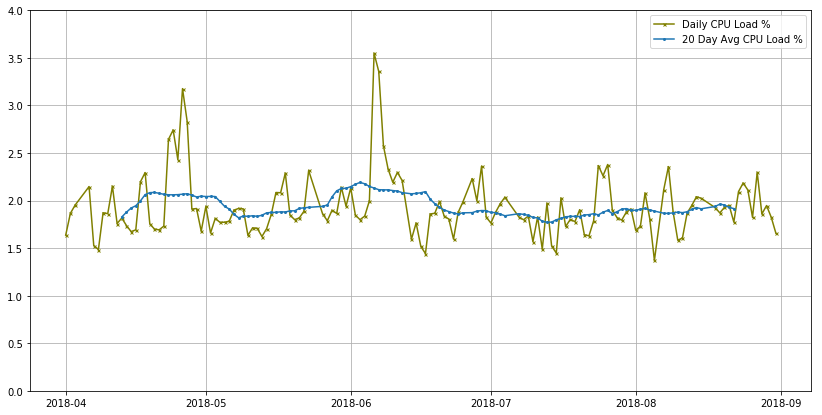

In [109]:
figure(figsize=(14,7))
plt.plot( df.index[:-22] , y_train, marker='x', color='olive', markersize=3, label = 'Daily CPU Load %')
plt.plot( df.index[:-22] , y_train.rolling(20, center=True).mean(), marker='o', markersize=2, label='20 Day Avg CPU Load %')
axes = plt.gca()
axes.set_ylim([0,4])
plt.legend()
plt.grid()

Indeed the ENM CPU load change is barely noticeable during the observation period, therefore this time we can't calculate the CPU load caused by 1 ERBS.

# 6. Computing CPU Load NE Equivalence on MSCMCE for Multiple Operators

Defining function `ne_eq_dffi_proc` which is going to do all the work for an opearator servers instance.

In [110]:
def ne_eq_dffi_proc(graph_fname, labels_fname, checkpoint_fname, ref_node):
    df = graph_to_df(graph_fname)
    df = add_avg_cpu(df, labels_fname)
    add_datepart(df, 'date', drop=False)
    df.set_index('date', inplace=True)
    df, supported_nodes = add_delta_node(df)
#     df = checkpoint(df, checkpoint_fname)   # commented because of warning messages
    X, y, X_train, X_test, y_train, y_test = train_test_split(df)
    dffi = df_feat_imp(X_train, y_train, supported_nodes)
    dffi = comp_ref(dffi, ref_node)
    delta_proc_load = (proc_load_end - proc_load_start) * dffi['importance %'].sum() / 100
    proc_load_ref_node = delta_proc_load / dffi[f'delta {ref_node}'].sum()
    return dffi, proc_load_ref_node

Calculating NE Equivalence on MSCMCE for all operators:

In [111]:
import glob

mscmce_graph_files = glob.glob(graph_dir + '*-mscmce-*')
mscmce_graph_files = [full_path.split(os.sep)[-1] for full_path in mscmce_graph_files]
mscmce_label_files = glob.glob(data_dir + 'labels-*-mscmce-*')
mscmce_label_files = [full_path.split(os.sep)[-1] for full_path in mscmce_label_files]
checkpoint_files = ['op'+str(i).zfill(2)+'-mscmce.ftr' for i in range(1,12)]
ref_node = 'RadioNode'
ref_node_proc_loads = {}

for graph_fname, labels_fname, checkpoint_fname in zip(mscmce_graph_files, mscmce_label_files, checkpoint_files):
    operator = checkpoint_fname[:4]
    dffi, proc_load_ref_node = ne_eq_dffi_proc(graph_fname, labels_fname, checkpoint_fname, ref_node)
    print(f'CPU Load caused by 1 {ref_node} on {operator} MSCMCE server instance = {proc_load_ref_node:.5f} %\n')
    print(dffi[dffi.columns[:-1]].head())
    ref_node_proc_loads[operator] = proc_load_ref_node 

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.6min finished


CPU Load caused by 1 RadioNode on op01 MSCMCE server instance = 0.00118 %

     feature  importance % first_value last_value node_diff  RadioNode Eq
0  RadioNode     98.285296           1       3379      3378      1.000000
1        WMG      0.138881           0          2         2      2.386618
2   SGSN-MME      0.095702           0          4         4      0.822301
3        EPG      0.040055           0          6         6      0.229443
4   MSRBS_V1      0.035097           0         20        20      0.060314
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.1min finished
C:\Users\ethneat\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


CPU Load caused by 1 RadioNode on op02 MSCMCE server instance = nan %

     feature  importance % first_value last_value node_diff RadioNode Eq
0  RadioNode           0.0        1656       1660         4         None
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.3min finished


CPU Load caused by 1 RadioNode on op03 MSCMCE server instance = 0.00247 %

     feature  importance % first_value last_value node_diff  RadioNode Eq
0  RadioNode     27.127555        3260       3706       446      1.000000
1   SGSN-MME     14.478742           4          6         2    119.021396
2   MSRBS_V1      6.205926          35         39         4     25.507669
3       SAPC      5.567470           2          8         6     15.255655
4        BSP      1.988159           0          3         3     10.895674
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.6min finished


CPU Load caused by 1 RadioNode on op04 MSCMCE server instance = 0.00115 %

     feature  importance % first_value last_value node_diff  RadioNode Eq
0  RadioNode     56.209667         328       2308      1980      1.000000
1   SGSN-MME     31.101943          12         17         5    219.114793
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.6min finished


CPU Load caused by 1 RadioNode on op05 MSCMCE server instance = 0.00160 %

     feature  importance % first_value last_value node_diff  RadioNode Eq
0  RadioNode     96.193811         136       2579      2443      1.000000
1   SGSN-MME      0.017816           0          3         3      0.150826
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.5min finished


CPU Load caused by 1 RadioNode on op06 MSCMCE server instance = 0.00188 %

     feature  importance % first_value last_value node_diff  RadioNode Eq
0  RadioNode     91.875758          57       2043      1986      1.000000
1   SGSN-MME      3.302143          10         13         3     23.793204
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.6min finished


CPU Load caused by 1 RadioNode on op07 MSCMCE server instance = 0.00220 %

     feature  importance % first_value last_value node_diff  RadioNode Eq
0  RadioNode     97.659613         164       1972      1808         1.000
1   SGSN-MME      0.014260           8         16         8         0.033
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.5min finished


CPU Load caused by 1 RadioNode on op08 MSCMCE server instance = 0.00196 %

     feature  importance % first_value last_value node_diff  RadioNode Eq
0  RadioNode     94.691477         123       2086      1963      1.000000
1   SGSN-MME      0.546981           8         20        12      0.944932
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.5min finished


CPU Load caused by 1 RadioNode on op09 MSCMCE server instance = 0.00081 %

     feature  importance % first_value last_value node_diff  RadioNode Eq
0  RadioNode     73.797168         400       4092      3692           1.0
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.5min finished


CPU Load caused by 1 RadioNode on op10 MSCMCE server instance = 0.00154 %

     feature  importance % first_value last_value node_diff  RadioNode Eq
0  RadioNode     69.008014         145       1973      1828      1.000000
1   SGSN-MME      0.667816           0          3         3      5.896744
Fitting 3 folds for each of 100 candidates, totalling 300 fits
CPU Load caused by 1 RadioNode on op11 MSCMCE server instance = 0.00151 %

     feature  importance % first_value last_value node_diff  RadioNode Eq
0  RadioNode     95.371629          20       2587      2567           1.0


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.6min finished


The CPU load caused by 1 `RadioNode` on different operators:

In [112]:
ref_node_proc_loads

{'op01': 0.0011831452341595227,
 'op02': nan,
 'op03': 0.002473346458724614,
 'op04': 0.001154396427099517,
 'op05': 0.0016011529482417952,
 'op06': 0.0018811821324712784,
 'op07': 0.002196472286573644,
 'op08': 0.0019615516423302074,
 'op09': 0.0008128064783243932,
 'op10': 0.0015350852322004271,
 'op11': 0.0015107843798370898}

Operator02 has to few datapoints and we couldn't get a valid CPU load estimate.  
On the rest of the Operators the RadioNode equivalent CPU load on MSCMCE is around 0.015% - 0.002%

Beside `RadioNode` mostly we have `SGSN-MME` nodes, but the equivalent CPU load caused by these nodes is either close to 1 `RadioNode` or in the range of 20..100 `RadioNode` - therefore we can't generalize these results.

# 7. Computing CPU Load NE Equivalence on MSCM for Multiple Operators

Calculating NE Equivalence on MSCM for all operators:

In [124]:
mscm_graph_files = glob.glob(graph_dir + '*-mscm-*')
mscm_graph_files = [full_path.split(os.sep)[-1] for full_path in mscm_graph_files]
mscm_label_files = glob.glob(data_dir + 'labels-*-mscm-*')
mscm_label_files = [full_path.split(os.sep)[-1] for full_path in mscm_label_files]
checkpoint_files = ['op'+str(i).zfill(2)+'-mscm.ftr' for i in range(1,12)]
ref_node = 'ERBS'
ref_node_proc_loads = {}

for graph_fname, labels_fname, checkpoint_fname in zip(mscm_graph_files, mscm_label_files, checkpoint_files):
    operator = checkpoint_fname[:4]
    dffi, proc_load_ref_node = ne_eq_dffi_proc(graph_fname, labels_fname, checkpoint_fname, ref_node)
    print(f'CPU Load caused by 1 {ref_node} on {operator} MSCM server instance = {proc_load_ref_node:.5f} %\n')
    print(dffi[dffi.columns[:-1]].head())
    ref_node_proc_loads[operator] = proc_load_ref_node 

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.5min finished


CPU Load caused by 1 ERBS on op01 MSCM server instance = 0.00303 %

  feature  importance % first_value last_value node_diff   ERBS Eq
0    ERBS     46.594128           3        629       626  1.000000
1     RBS     33.909822           3       2051      2048  0.222453
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.2min finished
C:\Users\ethneat\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


CPU Load caused by 1 ERBS on op02 MSCM server instance = nan %

  feature  importance % first_value last_value node_diff ERBS Eq
0    ERBS           0.0        2218       2218         0    None
1     RBS           0.0        4441       4441         0    None
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.3min finished


CPU Load caused by 1 ERBS on op03 MSCM server instance = 0.13079 %

  feature  importance % first_value last_value node_diff   ERBS Eq
0     RBS     11.838734        9163       9231        68  4.283377
1    ERBS     11.543258        1923       1639      -284  1.000000
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.6min finished


CPU Load caused by 1 ERBS on op04 MSCM server instance = -0.00193 %

  feature  importance % first_value last_value node_diff  ERBS Eq
0    ERBS     79.107598        6879       5208     -1671      1.0
1     MGW      0.000000          32         32         0      NaN
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.6min finished


CPU Load caused by 1 ERBS on op05 MSCM server instance = -0.00140 %

  feature  importance % first_value last_value node_diff  ERBS Eq
0    ERBS     72.368461        7735       5629     -2106      1.0
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.7min finished


CPU Load caused by 1 ERBS on op06 MSCM server instance = -0.00143 %

  feature  importance % first_value last_value node_diff     ERBS Eq
0    ERBS     64.970930        6583       4240     -2343    1.000000
1     MGW      7.574181          24         26         2  136.571128
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.6min finished


CPU Load caused by 1 ERBS on op07 MSCM server instance = -0.00167 %

  feature  importance % first_value last_value node_diff  ERBS Eq
0    ERBS      52.30618        7499       6228     -1271      1.0
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.6min finished


CPU Load caused by 1 ERBS on op08 MSCM server instance = -0.00335 %

  feature  importance % first_value last_value node_diff  ERBS Eq
0    ERBS     68.399072        5534       4703      -831      1.0
1     MGW      0.000000          30         30         0      NaN
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.7min finished


CPU Load caused by 1 ERBS on op09 MSCM server instance = -0.00132 %

  feature  importance % first_value last_value node_diff  ERBS Eq
0    ERBS     66.421646        4668       2622     -2046      1.0
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.6min finished


CPU Load caused by 1 ERBS on op10 MSCM server instance = -0.00638 %

  feature  importance % first_value last_value node_diff  ERBS Eq
0    ERBS      71.57497        3914       3458      -456      1.0
1     MGW       0.00000          26         26         0      NaN
Fitting 3 folds for each of 100 candidates, totalling 300 fits
CPU Load caused by 1 ERBS on op11 MSCM server instance = -0.00119 %

  feature  importance % first_value last_value node_diff  ERBS Eq
0    ERBS     74.446727        5882       3344     -2538      1.0


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.5min finished


The CPU load caused by 1 `ERBS` on different operators:

In [125]:
ref_node_proc_loads

{'op01': 0.0030266765313622444,
 'op02': nan,
 'op03': 0.13079115593644772,
 'op04': -0.0019250894115741073,
 'op05': -0.001397333681842259,
 'op06': -0.0014252032517841462,
 'op07': -0.0016734648899832355,
 'op08': -0.0033470202651283447,
 'op09': -0.0013201192471919256,
 'op10': -0.006382715540410802,
 'op11': -0.0011927876857101664}

- Operator01 is adding nodes to the server and here we equivalent CPU load caused by `ERBS` around ~0.003%
- Operator02 again has very few datapoints
- Operator03 is removing 284 ERBS but is adding 68 RBS and since 1 RBS is NE Equivalence is ~4 ERBS the two operations are cancelling each out and we can't trust the result for ERBS CPU load.
- Operator04..Operator11 are removing the `ERBS` nodes from MSCM and the CPU load is increasing - therefore we got negative results for the equivalent CPU load.  Again this is showing us that we ignored some important features which are influencing the CPU load.